# Process wav from AWS for orca calls below 1khz
Isabelle Brandicourt 11.1.2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ffmpeg
from scipy import signal
from scipy.signal import spectrogram, butter, filtfilt, welch
from scipy.io import wavfile
import warnings
import os
from pathlib import Path
import gc
import soundfile as sf

import pandas as pd # type: ignore
from pyproj import Proj # type: ignore

warnings.filterwarnings("error")
warnings.filterwarnings('ignore')

### Necessary functions:

read_wav_chunk
- this saves memory but pulling only the time chunk we want from the larger audio files saved on the device
- returns the WAV audio data for the duration defined by the user, starting at the defined start second in the audio file

butter_bandpass
- bandpasses the data using the butterworth method and the cutoffs defined by the user
- returns the filtered data

apply_fft 
- fourier transforms the filtered data, keeps only the real parts of the signal, and then normalizes with log scale for better contrast

psd_plot
- plots and saves the PSD plot in a folder in the working directory, under the same name as the WAV file

fft_plot
- plots the fourier transform and saves it in another folder, also under the same name as the WAV file

In [2]:
def read_wav_chunk(filename, start_sec, dur):
    # Read the file, then crop the data to the desired time chunk
    sample_rate, audio_data = wavfile.read(filename)
    start_sample = int(start_sec * sample_rate)
    end_sample = int((start_sec+dur) * sample_rate)
    if audio_data.ndim > 1:
        audio_data = audio_data[start_sample:end_sample, 0]
    else:
        audio_data = audio_data[start_sample:end_sample]
            
    return sample_rate, audio_data

def butter_bandpass(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def apply_fft(filtered_data, sample_rate):
    # FFT the filtered signal
    n = len(filtered_data)
    fft_data = np.fft.fft(filtered_data)
    freqs = np.fft.fftfreq(n, 1 / sample_rate)
    
    fft_data = np.abs(fft_data[:n // 2])
    freqs = freqs[:n // 2]
    
    fft_data = np.log(fft_data + np.finfo(float).eps)
    return freqs, fft_data

def psd_plot(freqs, psd, low, high, filename, alph, show_or_save):
    plt.figure(figsize=(8, 6))
    plt.semilogy(freqs, psd)
    plt.xlim([low, high])
    plt.ylim([0.0000001, 100000])
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power/Frequency [dB/Hz]')
    plt.title(f'Power Spectral Density (PSD) (bandpassed {low}-{high} Hz)')
    plt.grid(True)
    if show_or_save == 0:
        plt.show()
    else:
        folder = 'psd'
        plt.savefig(os.path.join(folder, f'{filename}_{alph}_PSD_{high}.png'))
        plt.close()

def fft_plot(freqs, fft_data, low, high, filename, alph, show_or_save):
    # Plot the FFT result (amplitude vs frequency) for the bandpassed region
    plt.figure(figsize=(8, 6))
    plt.plot(freqs, fft_data)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.xlim([low, high])
    plt.title(f'FFT of Orca Call ({low}-{high} Hz)')
    plt.grid(True)
    if show_or_save == 0:
        plt.show()
    else:
        folder = 'fft'
        plt.savefig(os.path.join(folder, f'{filename}_{alph}_FFT_{high}.png'))
        plt.close()

def filters(audio_data, lowcut, highcut, sample_rate, filename, alph, show_or_save):
    filtered_data = butter_bandpass(audio_data, lowcut, highcut, sample_rate)
    # Calculate PSD with Welch's method on cropped data (4096 for orca calls, 3072 is 75% overlap, hann for bio sounds, scaling for density)
    frequencies, psd = welch(filtered_data, fs=sample_rate, nperseg=4096, noverlap=3072, window='hann', scaling='density')
    psd_plot(frequencies, psd, 0, highcut, filename, alph, show_or_save)
    # Apply FFT to increase contrast
    freqs, fft_data = apply_fft(filtered_data, sample_rate)
    fft_plot(freqs, fft_data, 0, highcut, filename, alph, show_or_save)

    return filtered_data

def spectro_plot(fd, sample_rate, filename, alph, highcut, start_sec, dur, show_or_save):
    frequencies, times, Sxx = spectrogram(fd, fs=sample_rate, nperseg=4096, noverlap=3584, nfft=8192, window='hann')
    sxx_db = noise_floor(Sxx)
    vmx = np.percentile(sxx_db, 99)
    if highcut == 1000: v_max = 20
    elif highcut == 5000: v_max = vmx

    plt.figure(figsize=(15, 6))
    mesh = plt.pcolormesh(times, frequencies, sxx_db, shading='gouraud', cmap='viridis', vmax=v_max, vmin=-10)
    plt.colorbar(mesh, label='Intensity [dB]')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.title(f'{filename} (0-{highcut} Hz) (seconds {start_sec}-{start_sec+dur})')
    plt.ylim([0, highcut])
    if show_or_save == 0:
        plt.show()
    else:
        folder = 'spectros'
        plt.savefig(os.path.join(folder, f'{filename}_{alph}_{highcut}Hz.png'))
        plt.close()

def noise_floor(Sxx):
    # Better dB conversion with noise floor adjustment
    Sxx_dB = 10 * np.log10(Sxx + np.finfo(float).eps)
    noise_floor = np.percentile(Sxx_dB, 10)  # Adjust noise floor
    Sxx_dB = np.maximum(Sxx_dB, noise_floor)
    return Sxx_dB

### Process a single audio file and show the plots here

- You won't be able to see any whales if the file duration is much longer than 10 to 30-ish second chunks, so a longer file is segmented into smaller pieces

Sample rate: 44100, Cropped audio data shape: (1323000,)


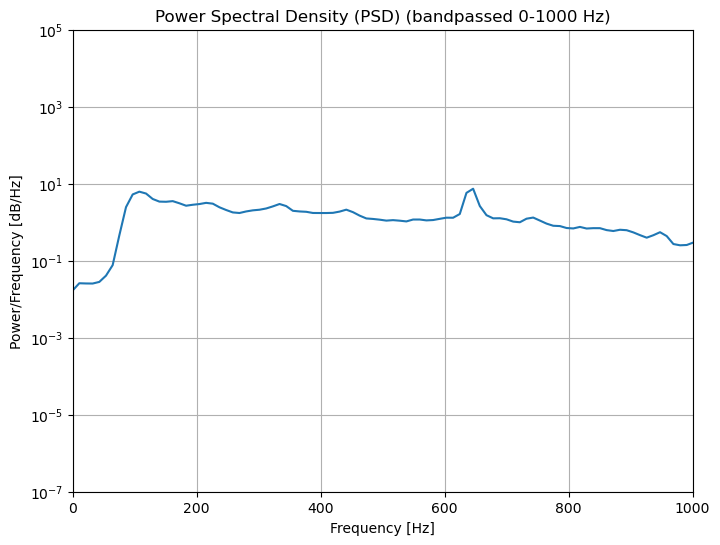

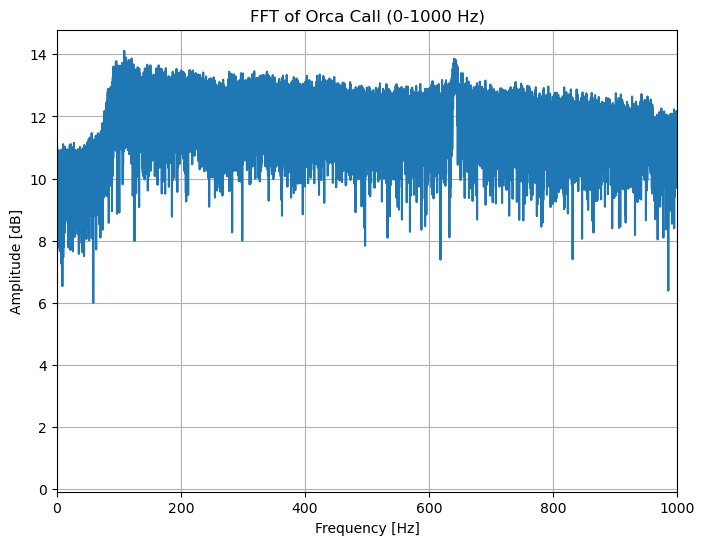

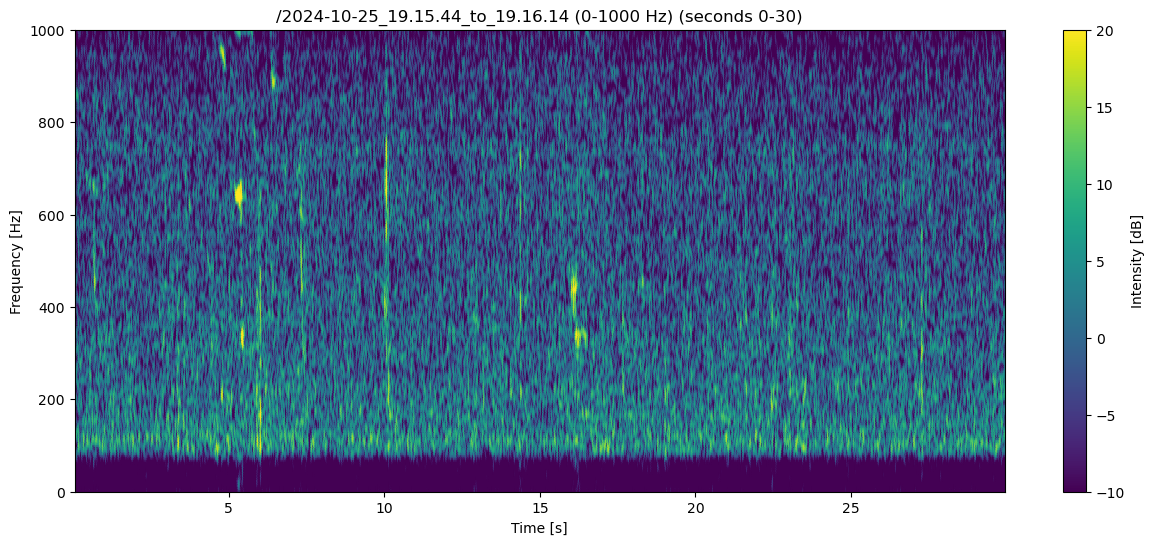

In [10]:
# Enter the file you want to run
file = "wavs/2024-10-25_19.15.44_to_19.16.14.wav"
filename=file[4:-4]

start_sec = 0
dur = 30
lowcut, highcut = 100, 1000
order = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']

os.makedirs("psd", exist_ok=True)
os.makedirs("fft", exist_ok=True)
os.makedirs("spectros", exist_ok=True)

sample_rate, audio_data = read_wav_chunk(file, start_sec, dur)
print(f"Sample rate: {sample_rate}, Cropped audio data shape: {audio_data.shape}")

filtered_data = filters(audio_data, lowcut, highcut, sample_rate, filename, order[0], 0) 
spectro_plot(filtered_data, sample_rate, filename, order[0], highcut, start_sec, dur, 0)

### Process all audio files in the WAV folder

- If a file is longer than 30 sec, it chunks it into equal parts and processes those so no part is longer that 30 secs
    (i.e. a 3 minute file would be parsed into 6 30s chunks but a 45 sec file would be parsed into 2 22s chunks)

In [3]:
folder_path = "/home/isabrand/Documents/ODL/Whidbey/Hydrophone/wavs"

start_sec = 0
dur = 30
lowcut, highcut = 200, 1000
order = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']

os.makedirs("psd", exist_ok=True)
os.makedirs("fft", exist_ok=True)
os.makedirs("spectros", exist_ok=True)

for f in os.listdir(folder_path):
    file_path = os.path.join(folder_path, f)
    filename = f[0:-4]
    if os.path.isfile(file_path):
        sample_rate, audio_data = wavfile.read(file_path)
        dur = round(audio_data.shape[0]/sample_rate, 2)
        max_size = 1330000
        chunks = [audio_data[i:i + max_size] for i in range(0, len(audio_data), max_size)]

        for ind, ch in enumerate(chunks):
            ch = ch[:, 0]
            filtered_data = filters(ch, lowcut, highcut, sample_rate, filename, order[ind], 1) 
            #spectro_plot(filtered_data, sample_rate, filename, order[ind], highcut, start_sec, dur, 1)
            del ch, filtered_data
            gc.collect()

    del audio_data, chunks
    gc.collect()